In [1]:
import numpy as np
import os, json, cv2, random

from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.structures import BoxMode
from detectron2.utils.file_io import PathManager
from detectron2.engine import DefaultTrainer, DefaultPredictor
from detectron2 import model_zoo
from detectron2.config import get_cfg

category_dict = {
    0: "person", #not pedestrian??
    1: "rider",
    2: "car",
    3: "truck",
    4: "bus",
    5: "train",
    6: "motor", #"motorcycle",
    7: "bike",# bicycle
    8: "traffic light",
    9: "traffic sign",
}

things_list = [category_dict[i] for i in range(10)]


In [2]:

def get_key_from_value(d, val):
    keys = [k for k, v in d.items() if v == val]
    if keys:
        return keys[0]
    return None


def get_bdd100k_dicts(img_dir, trainorval):
    json_file = os.path.join(img_dir, "labels", "bdd100k_labels_images_"+trainorval+".json")
    with open(json_file) as f:
        imgs_anns = json.load(f)

    dataset_dicts = []
    for idx, v in enumerate(imgs_anns):
        record = {}
        try:
            filename = os.path.join(img_dir, "images", "10k", trainorval, v["name"])
            height, width = cv2.imread(filename).shape[:2]
        except:
            continue
        record["file_name"] = filename
        record["image_id"] = idx
        record["height"] = height
        record["width"] = width
      
        annos = v["labels"]
        objs = []
        for anno in annos:
            try:
                box = anno["box2d"]
            except:
                continue
            obj = {
                "bbox": [box["x1"], box["y1"], box["x2"], box["y2"]],
                "bbox_mode": BoxMode.XYXY_ABS,
                "category_id": get_key_from_value(category_dict, anno["category"]),
            }
            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

In [3]:
for d in ["train", "val"]:
    DatasetCatalog.register("bdd100K_" + d, lambda d=d: get_bdd100k_dicts( "/home/konishi/bdd100k", d))
    MetadataCatalog.get("bdd100K_" + d).set(thing_classes=things_list)
bdd100K_metadata = MetadataCatalog.get("bdd100K_train")
dataset_dicts = get_bdd100k_dicts("/home/konishi/bdd100k", "train")

In [10]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("bdd100K_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 300    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 10
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[10/05 16:20:22 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_280758.pkl: 167MB [00:13, 12.7MB/s]                           
Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (11, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (11,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (40, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (40,) in the model! You might want to double check if this is expected.
Some model parameters or buffers are not found in the checkpoint:
roi_heads.box

[10/05 16:21:08 d2.engine.train_loop]: Starting training from iteration 0


/home/konishi/.local/lib/python3.8/site-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /pytorch/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)
/home/konishi/.local/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


[10/05 16:21:20 d2.utils.events]:  eta: 0:02:43  iter: 19  total_loss: 3.742  loss_cls: 2.444  loss_box_reg: 0.8304  loss_rpn_cls: 0.1938  loss_rpn_loc: 0.2431  time: 0.6194  data_time: 0.0099  lr: 1.6068e-05  max_mem: 2642M
[10/05 16:21:32 d2.utils.events]:  eta: 0:02:31  iter: 39  total_loss: 3.379  loss_cls: 2.202  loss_box_reg: 0.8873  loss_rpn_cls: 0.1352  loss_rpn_loc: 0.2053  time: 0.6031  data_time: 0.0028  lr: 3.2718e-05  max_mem: 2642M
[10/05 16:21:43 d2.utils.events]:  eta: 0:02:19  iter: 59  total_loss: 2.798  loss_cls: 1.638  loss_box_reg: 0.8236  loss_rpn_cls: 0.1194  loss_rpn_loc: 0.2348  time: 0.5902  data_time: 0.0032  lr: 4.9367e-05  max_mem: 2642M
[10/05 16:21:55 d2.utils.events]:  eta: 0:02:08  iter: 79  total_loss: 2.185  loss_cls: 1.04  loss_box_reg: 0.8313  loss_rpn_cls: 0.06537  loss_rpn_loc: 0.2523  time: 0.5938  data_time: 0.0030  lr: 6.6017e-05  max_mem: 2642M
[10/05 16:22:07 d2.utils.events]:  eta: 0:01:56  iter: 99  total_loss: 1.964  loss_cls: 0.8103  loss

In [11]:
%load_ext tensorboard
%tensorboard --logdir output

In [12]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

In [14]:
from detectron2.utils.visualizer import ColorMode
from detectron2.utils.visualizer import Visualizer
import matplotlib.pyplot as plt

dataset_dicts = get_bdd100k_dicts("/home/konishi/bdd100k", "val")
fig = plt.figure(figsize=(16, 16))

for i, d in enumerate(random.sample(dataset_dicts, 3)):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:, :, ::-1],
                   metadata=bdd100K_metadata, 
                   scale=0.5, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    ax = fig.add_subplot(1, 3, i+1)
    ax.imshow(out.get_image()[:, :, :])
    ax.axis("off")

ValueError: Sample larger than population or is negative

<Figure size 1152x1152 with 0 Axes>

In [15]:
len(dataset_dicts)

0

## 100K data

In [1]:
import numpy as np
import os, json, cv2, random
import matplotlib.pyplot as plt

from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.structures import BoxMode
from detectron2.utils.file_io import PathManager
from detectron2.engine import DefaultTrainer, DefaultPredictor
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.utils.visualizer import ColorMode, Visualizer


category_dict = {
    0: "person", #not pedestrian??
    1: "rider",
    2: "car",
    3: "truck",
    4: "bus",
    5: "train",
    6: "motor", #motorcycle,
    7: "bike",# bicycle
    8: "traffic light",
    9: "traffic sign",
}

things_list = [category_dict[i] for i in range(10)]

def get_key_from_value(d, val):
    keys = [k for k, v in d.items() if v == val]
    if keys:
        return keys[0]
    return None


def get_bdd100k_dicts(img_dir, trainorval):
    json_file = os.path.join(img_dir, "labels", "bdd100k_labels_images_"+trainorval+".json")
    with open(json_file) as f:
        imgs_anns = json.load(f)

    dataset_dicts = []
    for idx, v in enumerate(imgs_anns):
        record = {}
        try:
            filename = os.path.join(img_dir, "images", "100k", trainorval, v["name"])
            height, width = cv2.imread(filename).shape[:2]
        except:
            continue
        record["file_name"] = filename
        record["image_id"] = idx
        record["height"] = height
        record["width"] = width
      
        annos = v["labels"]
        objs = []
        for anno in annos:
            try:
                box = anno["box2d"]
            except:
                continue
            obj = {
                "bbox": [box["x1"], box["y1"], box["x2"], box["y2"]],
                "bbox_mode": BoxMode.XYXY_ABS,
                "category_id": get_key_from_value(category_dict, anno["category"]),
            }
            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts




In [2]:
for d in ["train", "val"]:
    DatasetCatalog.register("bdd100K_" + d, lambda d=d: get_bdd100k_dicts( "/home/konishi/bdd100k", d))
    MetadataCatalog.get("bdd100K_" + d).set(thing_classes=things_list)
bdd100K_metadata = MetadataCatalog.get("bdd100K_train")
dataset_dicts = get_bdd100k_dicts("/home/konishi/bdd100k", "train")


In [3]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("bdd100K_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 300    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 10

# train
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[10/06 09:26:49 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (11, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (11,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (40, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (40,) in the model! You might want to double check if this is expected.
Some model parameters or buffers are not found in the checkpoint:
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias

[10/06 09:35:36 d2.engine.train_loop]: Starting training from iteration 0


/home/konishi/.local/lib/python3.8/site-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /pytorch/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)
/home/konishi/.local/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


[10/06 09:35:50 d2.utils.events]:  eta: 0:03:23  iter: 19  total_loss: 3.347  loss_cls: 2.091  loss_box_reg: 0.8419  loss_rpn_cls: 0.1736  loss_rpn_loc: 0.2234  time: 0.7123  data_time: 0.0114  lr: 1.6068e-05  max_mem: 2643M
[10/06 09:36:04 d2.utils.events]:  eta: 0:03:09  iter: 39  total_loss: 3.017  loss_cls: 1.838  loss_box_reg: 0.8282  loss_rpn_cls: 0.101  loss_rpn_loc: 0.2219  time: 0.7112  data_time: 0.0030  lr: 3.2718e-05  max_mem: 2643M
[10/06 09:36:19 d2.utils.events]:  eta: 0:02:55  iter: 59  total_loss: 2.481  loss_cls: 1.327  loss_box_reg: 0.8437  loss_rpn_cls: 0.1196  loss_rpn_loc: 0.2591  time: 0.7126  data_time: 0.0031  lr: 4.9367e-05  max_mem: 2643M
[10/06 09:36:33 d2.utils.events]:  eta: 0:02:40  iter: 79  total_loss: 2.121  loss_cls: 0.9384  loss_box_reg: 0.8295  loss_rpn_cls: 0.09406  loss_rpn_loc: 0.2845  time: 0.7069  data_time: 0.0029  lr: 6.6017e-05  max_mem: 2643M
[10/06 09:36:47 d2.utils.events]:  eta: 0:02:25  iter: 99  total_loss: 1.928  loss_cls: 0.8088  los

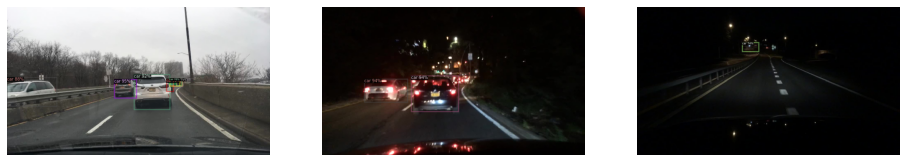

In [5]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

dataset_dicts = get_bdd100k_dicts("/home/konishi/bdd100k", "val")
fig = plt.figure(figsize=(16, 16))

for i, d in enumerate(random.sample(dataset_dicts, 3)):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:, :, ::-1],
                metadata=bdd100K_metadata, 
                scale=0.5, 
                instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    ax = fig.add_subplot(1, 3, i+1)
    ax.imshow(out.get_image()[:, :, :])
    ax.axis("off")

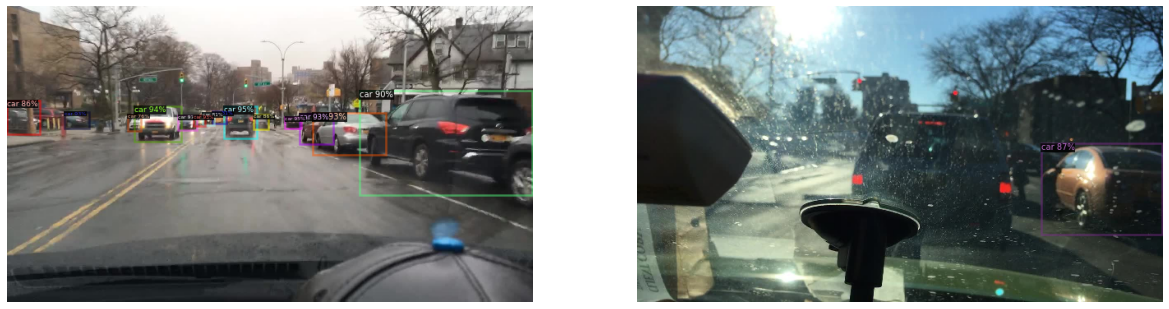

In [7]:
fig = plt.figure(figsize=(32, 32))

for i, d in enumerate(random.sample(dataset_dicts, 2)):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:, :, ::-1],
                metadata=bdd100K_metadata, 
                scale=0.5, 
                instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    ax = fig.add_subplot(1, 3, i+1)
    ax.imshow(out.get_image()[:, :, :])
    ax.axis("off")

In [10]:
px = [618,657,688,707,741,760,779,791,820,836,844,860,868,871,871,868,864,854,840,824,809,795,778,759,741,719,699,677,664,641,623,606,601,582,567,554,535,534,543,560,579,597,618]
py = [385,370,365,365,373,382,390,404,432,451,472,507,541,561,589,612,635,668,698,727,752,764,784,807,804,803,805,811,796,772,754,735,729,704,682,648,593,530,483,446,420,401,385]

poly = [(x + 0.5, y + 0.5) for x, y in zip(px, py)]
poly = [p for x in poly for p in x]
poly

[618.5,
 385.5,
 657.5,
 370.5,
 688.5,
 365.5,
 707.5,
 365.5,
 741.5,
 373.5,
 760.5,
 382.5,
 779.5,
 390.5,
 791.5,
 404.5,
 820.5,
 432.5,
 836.5,
 451.5,
 844.5,
 472.5,
 860.5,
 507.5,
 868.5,
 541.5,
 871.5,
 561.5,
 871.5,
 589.5,
 868.5,
 612.5,
 864.5,
 635.5,
 854.5,
 668.5,
 840.5,
 698.5,
 824.5,
 727.5,
 809.5,
 752.5,
 795.5,
 764.5,
 778.5,
 784.5,
 759.5,
 807.5,
 741.5,
 804.5,
 719.5,
 803.5,
 699.5,
 805.5,
 677.5,
 811.5,
 664.5,
 796.5,
 641.5,
 772.5,
 623.5,
 754.5,
 606.5,
 735.5,
 601.5,
 729.5,
 582.5,
 704.5,
 567.5,
 682.5,
 554.5,
 648.5,
 535.5,
 593.5,
 534.5,
 530.5,
 543.5,
 483.5,
 560.5,
 446.5,
 579.5,
 420.5,
 597.5,
 401.5,
 618.5,
 385.5]